# Project Notebook

## Imports

In [1]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Add, Input
from keras.models import Model
from tensorflow.nn import depth_to_space
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint
from PIL import Image
import math
from scipy.signal import convolve2d

2022-05-19 16:51:50.389509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 16:51:50.389534: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from load_data import loadDataR09, loadDataR18
from utils import *
from SRCNN import getModel, compileModel, trainModel
from DIPCI import compile, train

## LOAD DATA

In [3]:
upscale_factor = 4

Experiment on higher resolution data:

In [4]:
ssh_R09, sst_R09, ssh_R09_norm, sst_R09_norm, ssh_R36, sst_R18 = loadDataR09( upscale_factor )

Experiment on small resolution data : 

In [5]:
ssh_R18, sst_R18, ssh_R18_norm, sst_R18_norm, ssh_R72, sst_R36 = loadDataR18( upscale_factor )

## SRCNN 

In [6]:
srcnn, callbacks, epochs, checkpoint_filepath = compileModel()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    4624      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

2022-05-19 15:53:58.356925: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-19 15:53:58.356953: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2022-05-19 15:53:58.357433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Small Resolution 

(Training might be skipped)

Epoch 1/100
23/23 [==============================] - 1s 23ms/step - loss: 0.0055 - mse: 0.0055 - PSNR: 22.6576 - val_loss: 0.0042 - val_mse: 0.0042 - val_PSNR: 23.7735
Epoch 2/100
23/23 [==============================] - 1s 24ms/step - loss: 0.0040 - mse: 0.0040 - PSNR: 24.0458 - val_loss: 0.0033 - val_mse: 0.0033 - val_PSNR: 24.8417
Epoch 3/100
23/23 [==============================] - 1s 24ms/step - loss: 0.0033 - mse: 0.0033 - PSNR: 24.9032 - val_loss: 0.0028 - val_mse: 0.0028 - val_PSNR: 25.5198
Epoch 4/100
23/23 [==============================] - 1s 25ms/step - loss: 0.0029 - mse: 0.0029 - PSNR: 25.4594 - val_loss: 0.0026 - val_mse: 0.0026 - val_PSNR: 25.9419
Epoch 5/100
23/23 [==============================] - 1s 23ms/step - loss: 0.0026 - mse: 0.0026 - PSNR: 25.8799 - val_loss: 0.0024 - val_mse: 0.0024 - val_PSNR: 26.2573
Epoch 6/100
23/23 [==============================] - 1s 24ms/step - loss: 0.0024 - mse: 0.0024 - PSNR: 26.2458 - val_loss: 0.0022 - val_mse: 0.0022 - val_PSNR: 

Epoch 95/100
23/23 [==============================] - 1s 22ms/step - loss: 8.2389e-04 - mse: 8.2389e-04 - PSNR: 30.8703 - val_loss: 0.0010 - val_mse: 0.0010 - val_PSNR: 29.9024
Epoch 96/100
23/23 [==============================] - 1s 22ms/step - loss: 8.1979e-04 - mse: 8.1979e-04 - PSNR: 30.8913 - val_loss: 0.0010 - val_mse: 0.0010 - val_PSNR: 29.9188


INFO:tensorflow:Assets written to: tmp/model/srcnn/assets


INFO:tensorflow:Assets written to: tmp/model/srcnn/assets


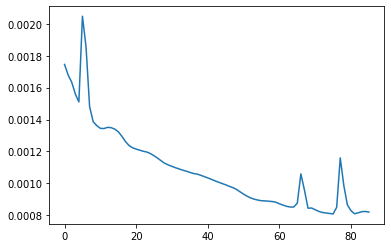

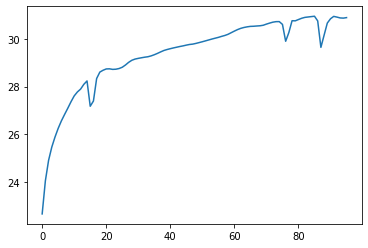

In [11]:
batch_size = 16
trainModel( srcnn, batch_size, ssh_R72, ssh_R18_norm, callbacks, epochs )

#### Results

In [16]:
srcnn.load_weights(checkpoint_filepath)

In [17]:
save_path = "./Save/exp1_srcnn_plot"
bicubic_predictions, bicubic_rmse, bicubic_psnr = bicubicMetrics( ssh_R72, ssh_R18 )
srcnn_predictions, srcnn_rmse, srcnn_psnr = srcnnMetrics( srcnn, ssh_R72, ssh_R18)

print("Average bicubic RMSE (m): ", np.mean(bicubic_rmse))
print("Average bicubic PSNR: ", np.mean(bicubic_psnr))
print("Average srcnn RMSE (m): ", np.mean(srcnn_rmse))
print("Average srcnn PSNR: ", np.mean(srcnn_psnr))

Average bicubic RMSE (m):  0.14560837199765492
Average bicubic PSNR:  23.04621296821734
Average srcnn RMSE (m):  0.1027978152913391
Average srcnn PSNR:  26.08545062531277


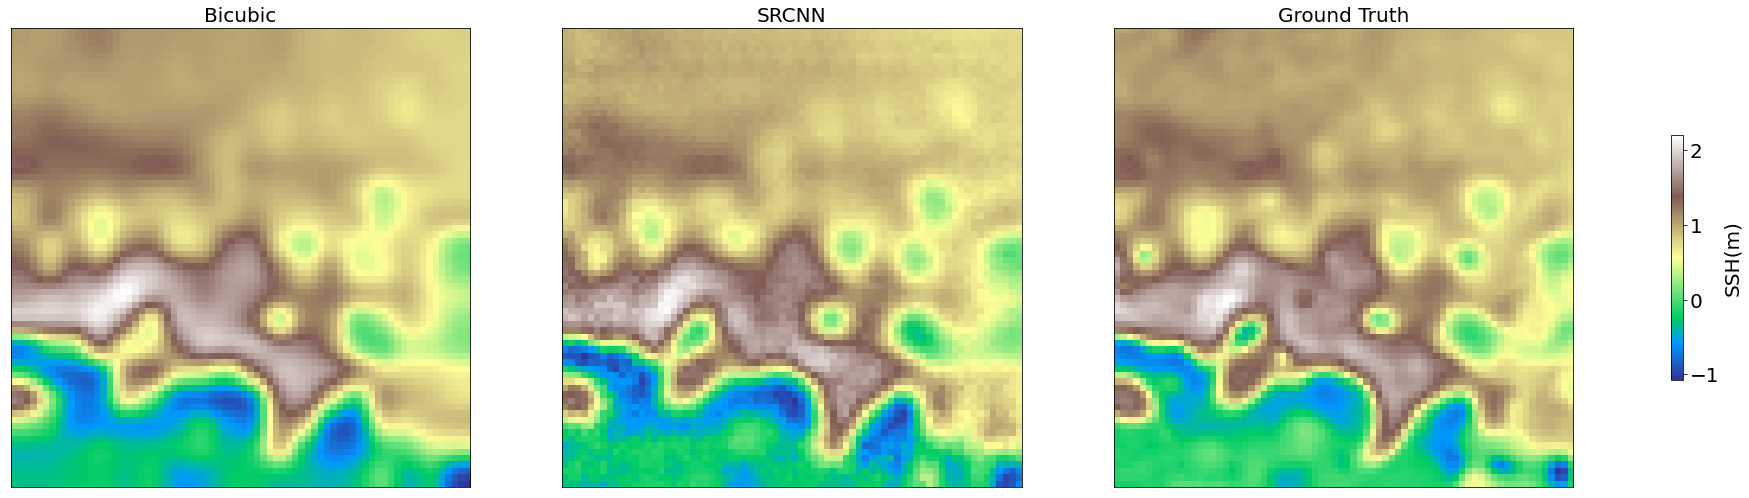

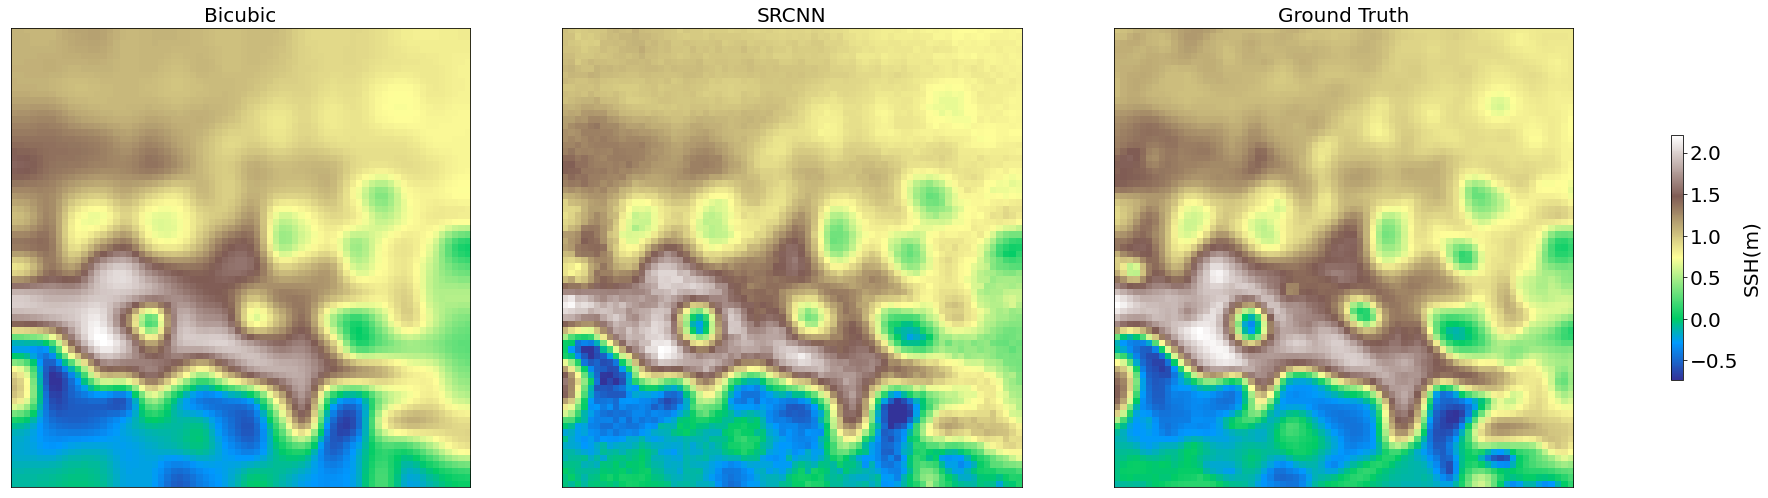

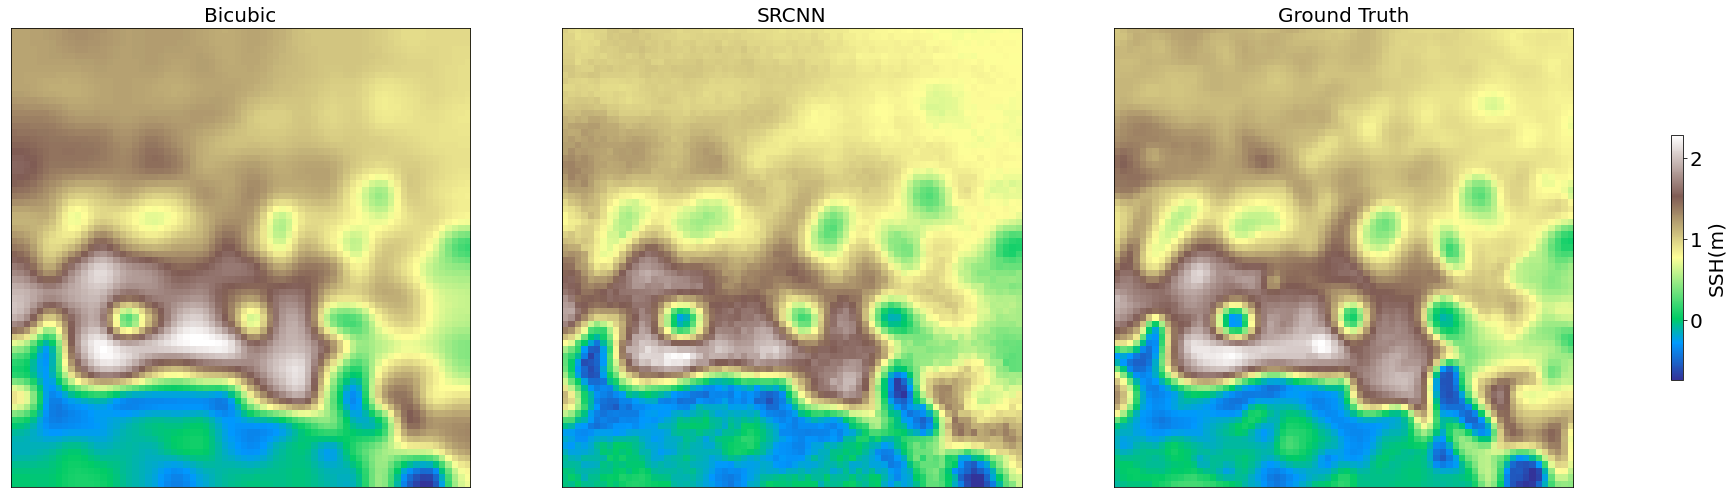

In [18]:
for i in range(3):
    plot_line([bicubic_predictions[i*10], srcnn_predictions[i*10], ssh_R18[i*10]], ["Bicubic", "SRCNN", "Ground Truth"], "terrain", save_path+str(i), center_colormap=False)

*comment* : we already observe how bicubic interpolation has the tendancy to blur edges compared to our method

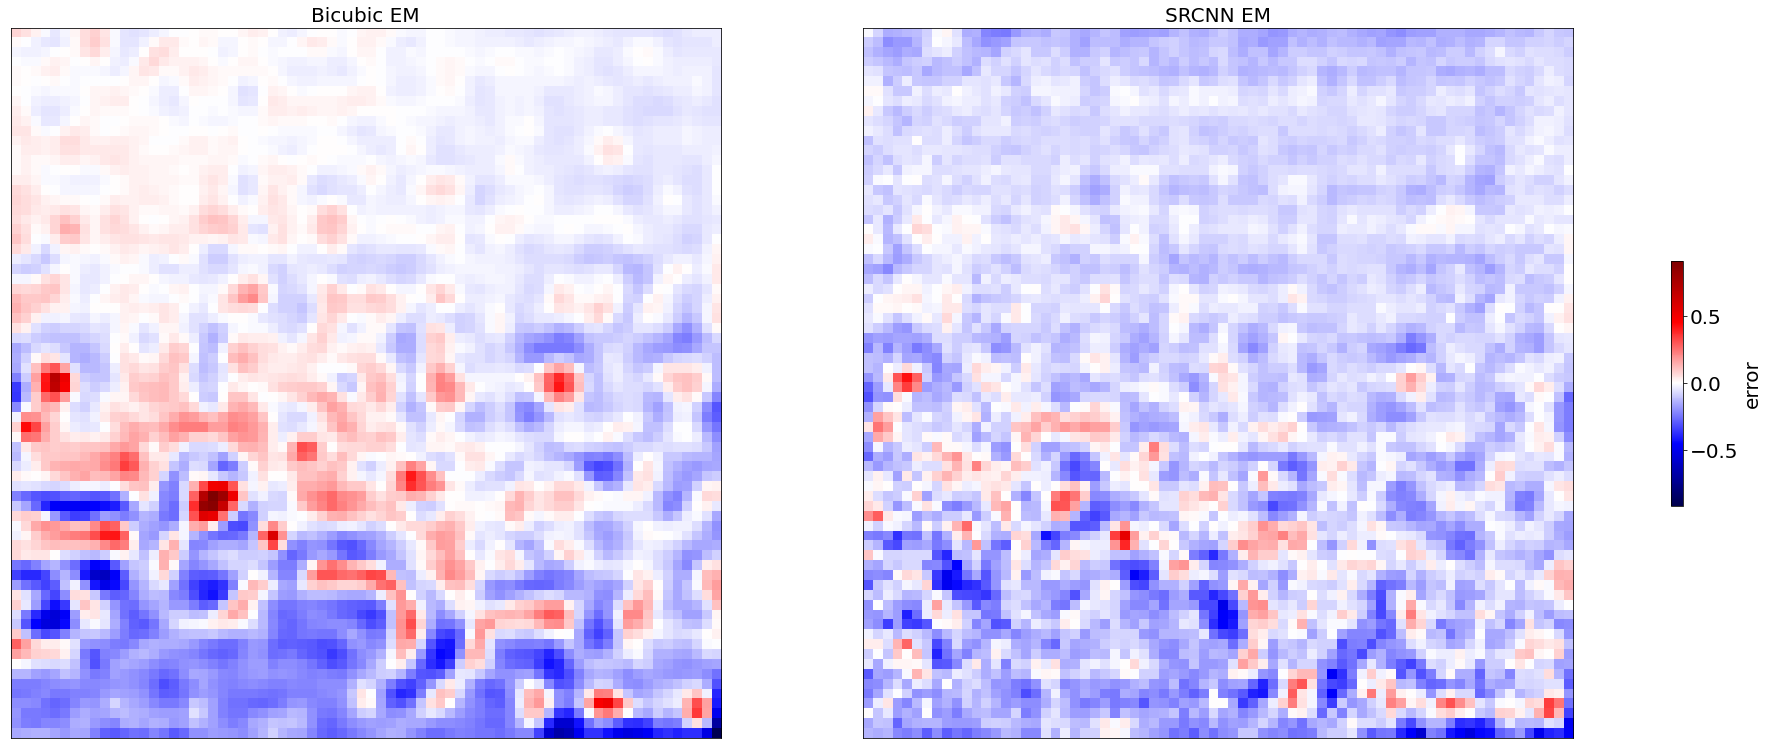

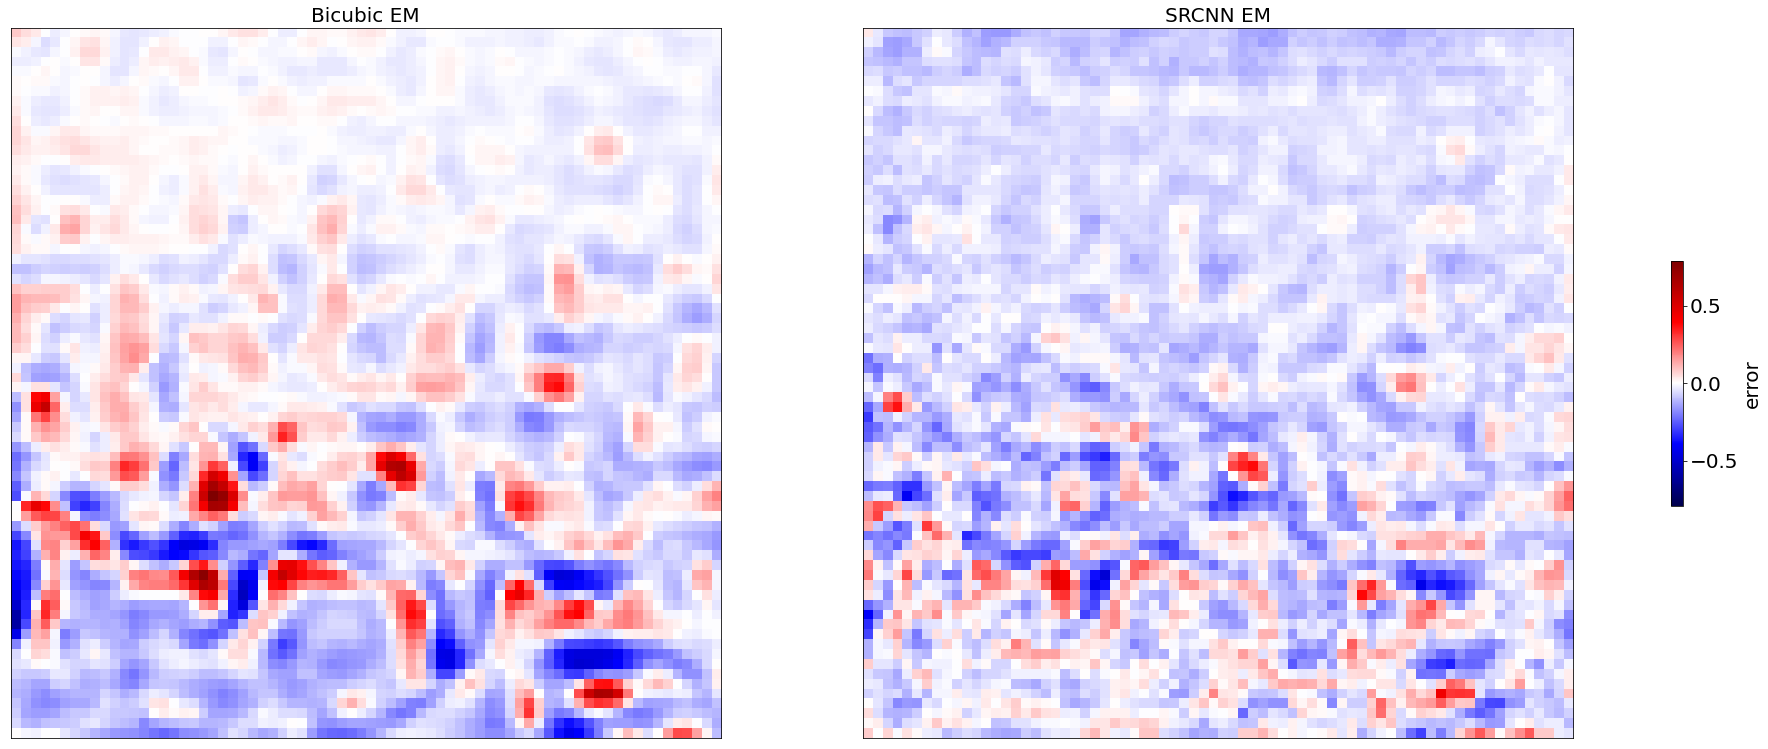

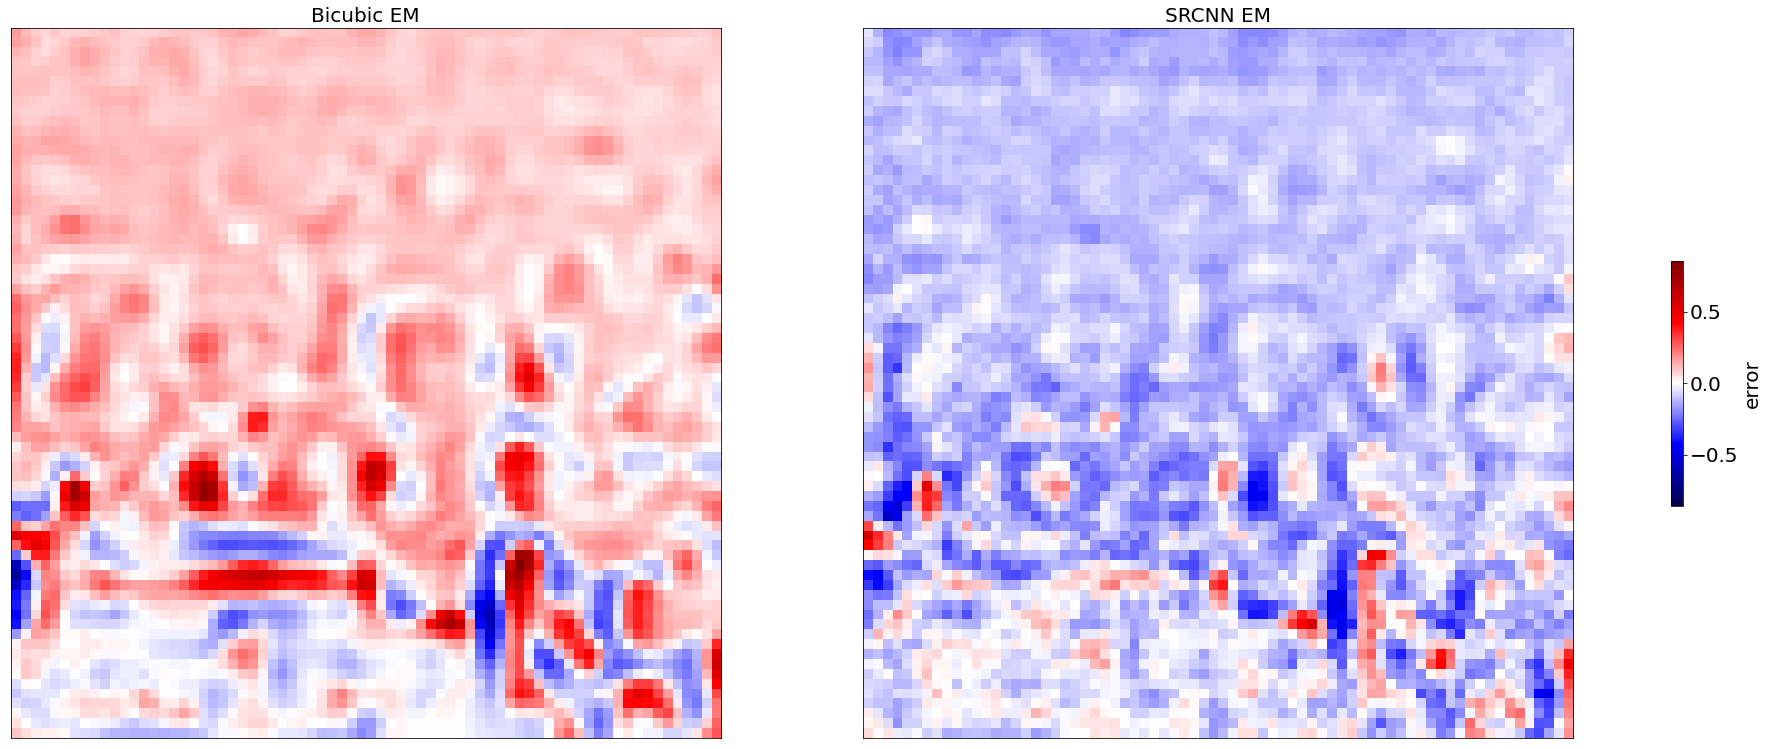

In [19]:
save_path = "./Save/exp1_srcnn_em"
for i in range(0,30,10):
    plot_line(
        [bicubic_predictions[i]-ssh_R18[i], srcnn_predictions[i]-ssh_R18[i]], 
        ["Bicubic EM", "SRCNN EM"], 
        "seismic",
        save_path+str(i), 
        label="error",
        center_colormap=True
    )

*comment :* same idea here, bicubic error are high and homogeneous around edges (related to blurred edges),
while srcnn errors are more punctual, especially and tiny regions.

### High resolution

Epoch 1/100
23/23 [==============================] - 2s 90ms/step - loss: 0.0057 - mse: 0.0057 - PSNR: 27.0050 - val_loss: 0.0035 - val_mse: 0.0035 - val_PSNR: 24.6316
Epoch 2/100
23/23 [==============================] - 2s 87ms/step - loss: 0.0015 - mse: 0.0015 - PSNR: 28.8671 - val_loss: 5.3413e-04 - val_mse: 5.3413e-04 - val_PSNR: 32.7517
Epoch 3/100
23/23 [==============================] - 2s 86ms/step - loss: 4.0836e-04 - mse: 4.0836e-04 - PSNR: 34.0230 - val_loss: 2.6865e-04 - val_mse: 2.6865e-04 - val_PSNR: 35.7554
Epoch 4/100
23/23 [==============================] - 2s 86ms/step - loss: 2.5674e-04 - mse: 2.5674e-04 - PSNR: 35.9503 - val_loss: 2.0903e-04 - val_mse: 2.0903e-04 - val_PSNR: 36.8434
Epoch 5/100
23/23 [==============================] - 2s 87ms/step - loss: 2.1601e-04 - mse: 2.1601e-04 - PSNR: 36.6977 - val_loss: 1.8623e-04 - val_mse: 1.8623e-04 - val_PSNR: 37.3447
Epoch 6/100
23/23 [==============================] - 2s 87ms/step - loss: 1.9449e-04 - mse: 1.9449e-04 -

23/23 [==============================] - 2s 105ms/step - loss: 2.1462e-04 - mse: 2.1462e-04 - PSNR: 37.7407 - val_loss: 1.6741e-04 - val_mse: 1.6741e-04 - val_PSNR: 37.8074
Epoch 90/100
23/23 [==============================] - 2s 98ms/step - loss: 1.8805e-04 - mse: 1.8805e-04 - PSNR: 37.9595 - val_loss: 1.2729e-04 - val_mse: 1.2729e-04 - val_PSNR: 39.0043
Epoch 91/100
23/23 [==============================] - 2s 95ms/step - loss: 9.9249e-05 - mse: 9.9249e-05 - PSNR: 40.1742 - val_loss: 8.1674e-05 - val_mse: 8.1674e-05 - val_PSNR: 40.9627
Epoch 92/100
23/23 [==============================] - 2s 93ms/step - loss: 8.5385e-05 - mse: 8.5385e-05 - PSNR: 40.7910 - val_loss: 7.7315e-05 - val_mse: 7.7315e-05 - val_PSNR: 41.2100
Epoch 93/100
23/23 [==============================] - 2s 93ms/step - loss: 8.4471e-05 - mse: 8.4471e-05 - PSNR: 40.8373 - val_loss: 7.6585e-05 - val_mse: 7.6585e-05 - val_PSNR: 41.2510
Epoch 94/100
23/23 [==============================] - 2s 95ms/step - loss: 8.4168e-05 -

INFO:tensorflow:Assets written to: tmp/model/srcnn/assets


INFO:tensorflow:Assets written to: tmp/model/srcnn/assets


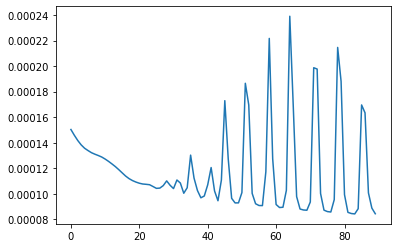

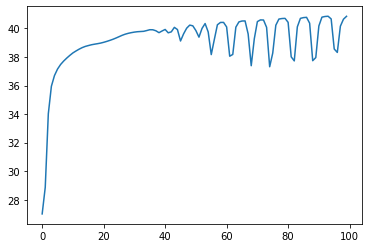

In [20]:
batch_size = 16
trainModel( srcnn, batch_size, ssh_R36, ssh_R09_norm, callbacks, epochs )

In [21]:
srcnn.load_weights(checkpoint_filepath)

In [22]:
save_path = "./Save/exp2_srcnn_plot"
bicubic_predictions, bicubic_rmse, bicubic_psnr = bicubicMetrics( ssh_R36, ssh_R09 )
srcnn_predictions, srcnn_rmse, srcnn_psnr = srcnnMetrics( srcnn, ssh_R36, ssh_R09)

print("Average bicubic RMSE (m): ", np.mean(bicubic_rmse))
print("Average bicubic PSNR: ", np.mean(bicubic_psnr))
print("Average srcnn RMSE (m): ", np.mean(srcnn_rmse))
print("Average srcnn PSNR: ", np.mean(srcnn_psnr))

Average bicubic RMSE (m):  0.027453032120097542
Average bicubic PSNR:  31.76214629124577
Average srcnn RMSE (m):  0.017521265108724645
Average srcnn PSNR:  35.67291396742232


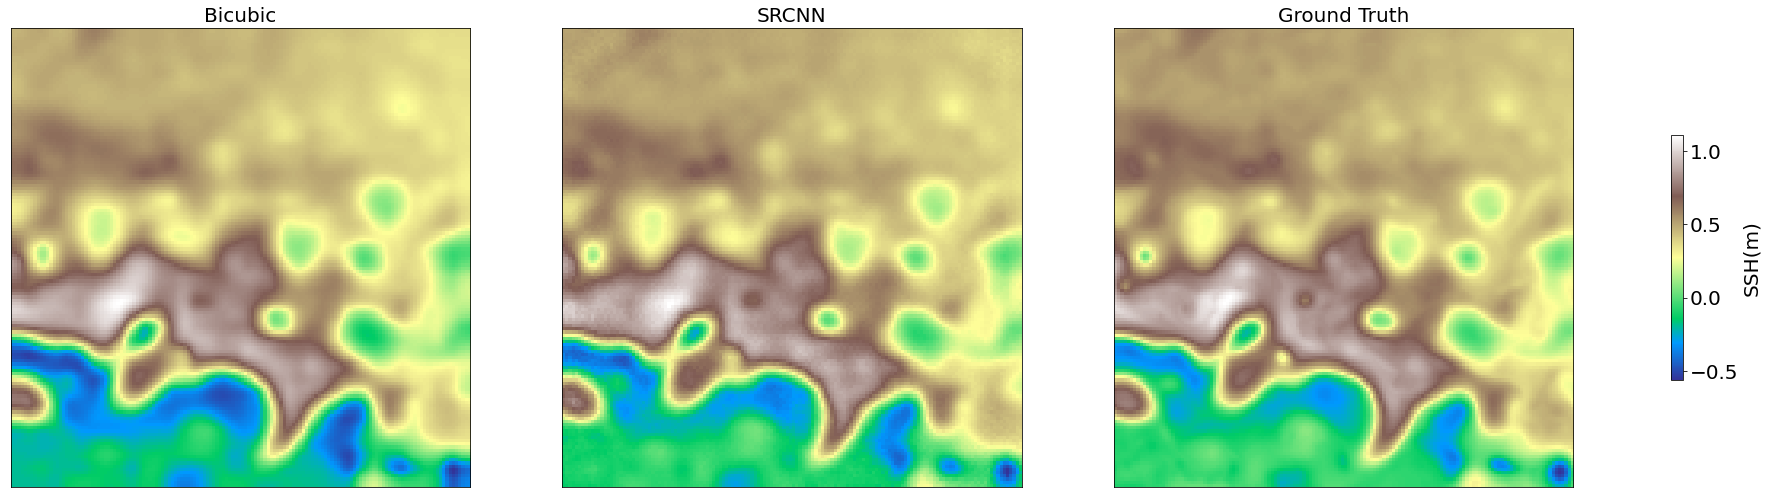

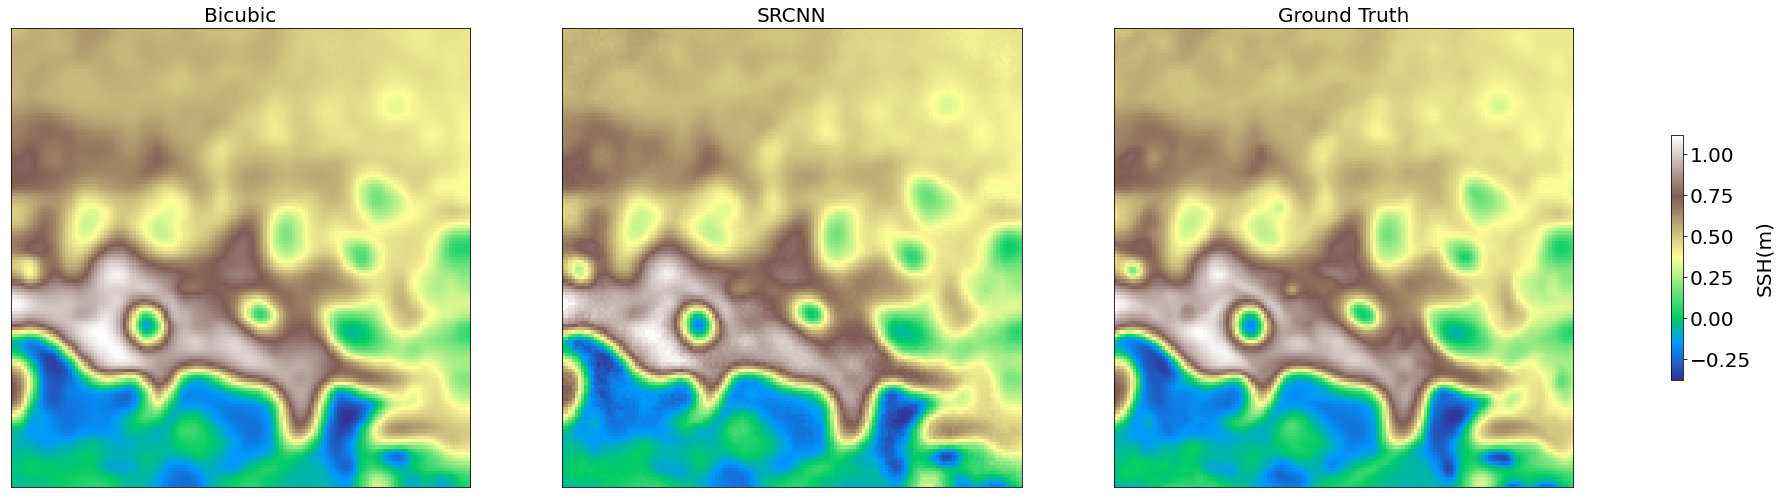

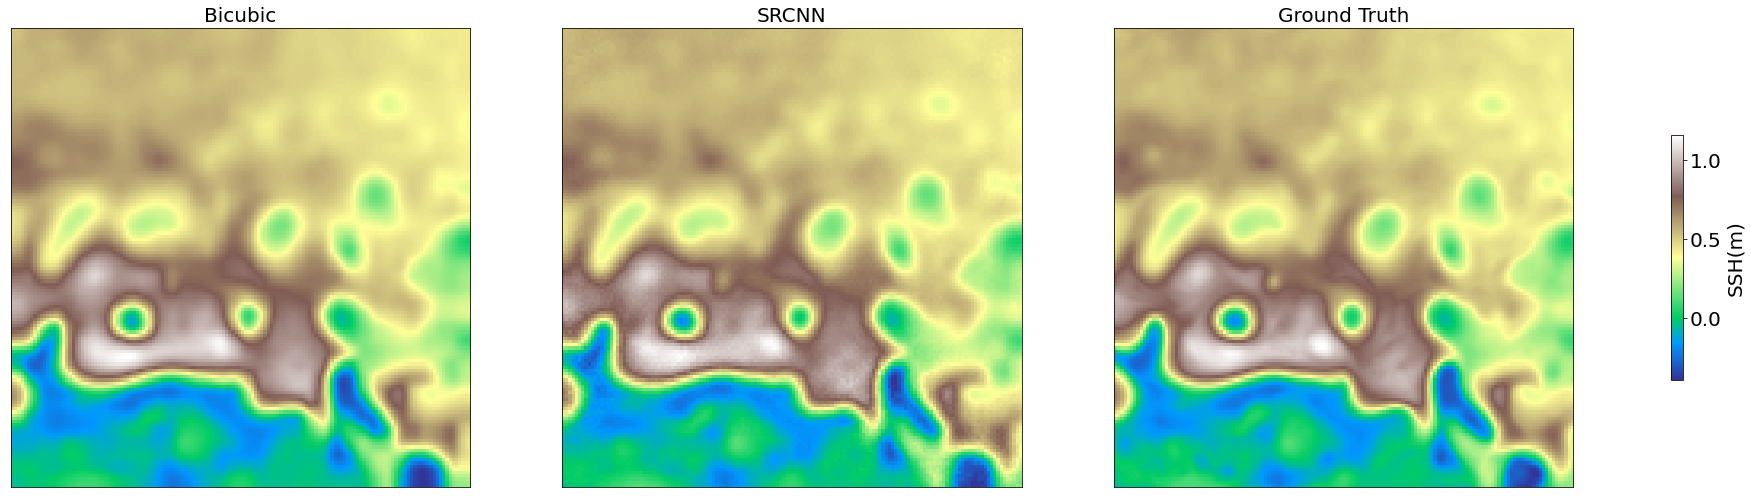

In [23]:
for i in range(3):
    plot_line(
        [bicubic_predictions[i*10], 
         srcnn_predictions[i*10], 
         ssh_R09[i*10]], 
        ["Bicubic", "SRCNN", "Ground Truth"], 
        "terrain", 
        save_path+str(i), 
        center_colormap=False
    )

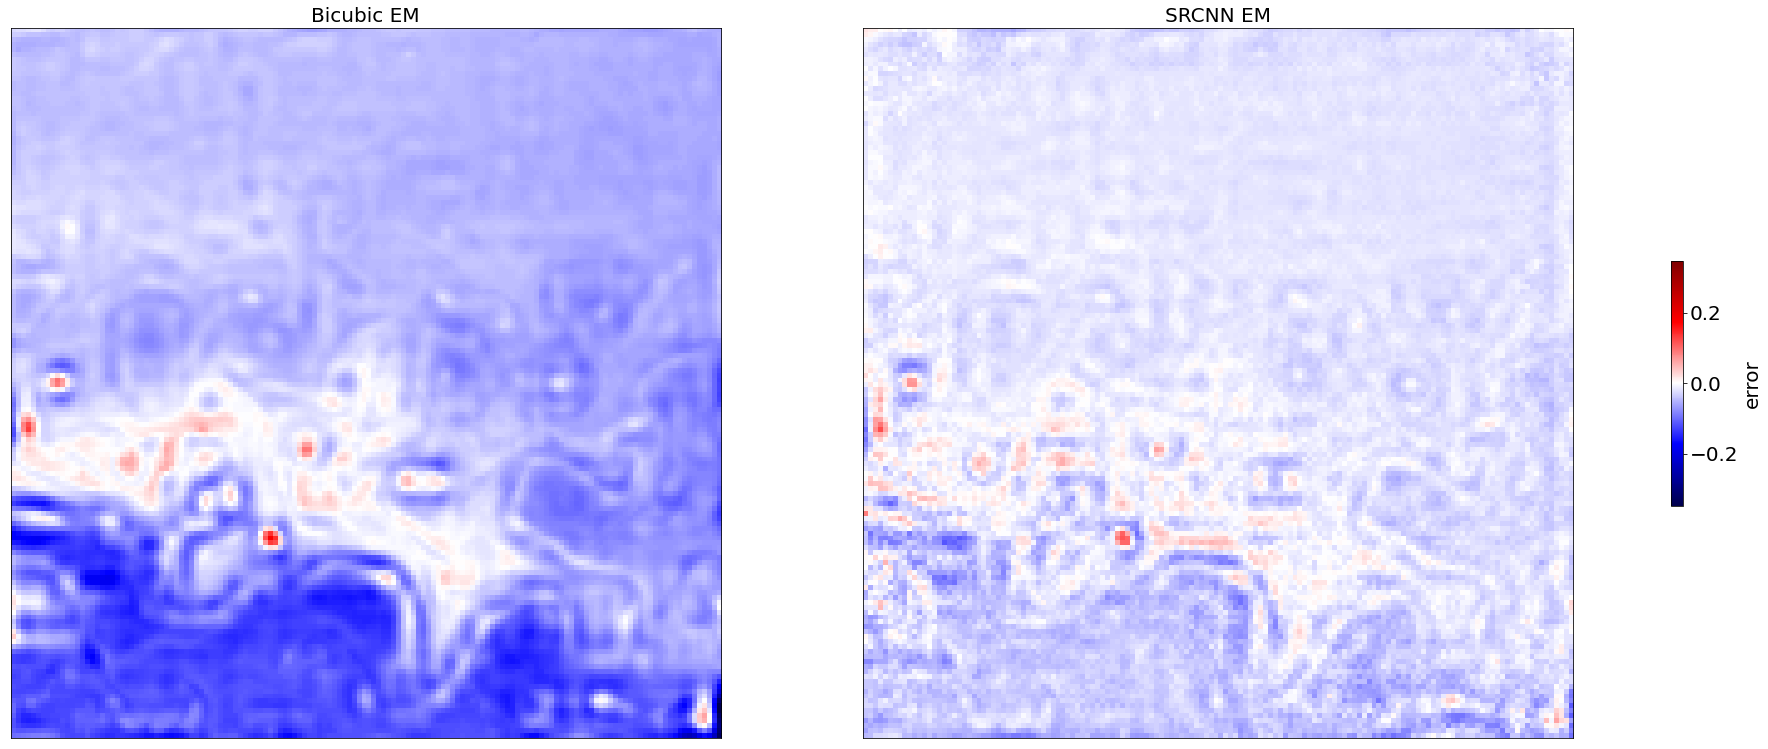

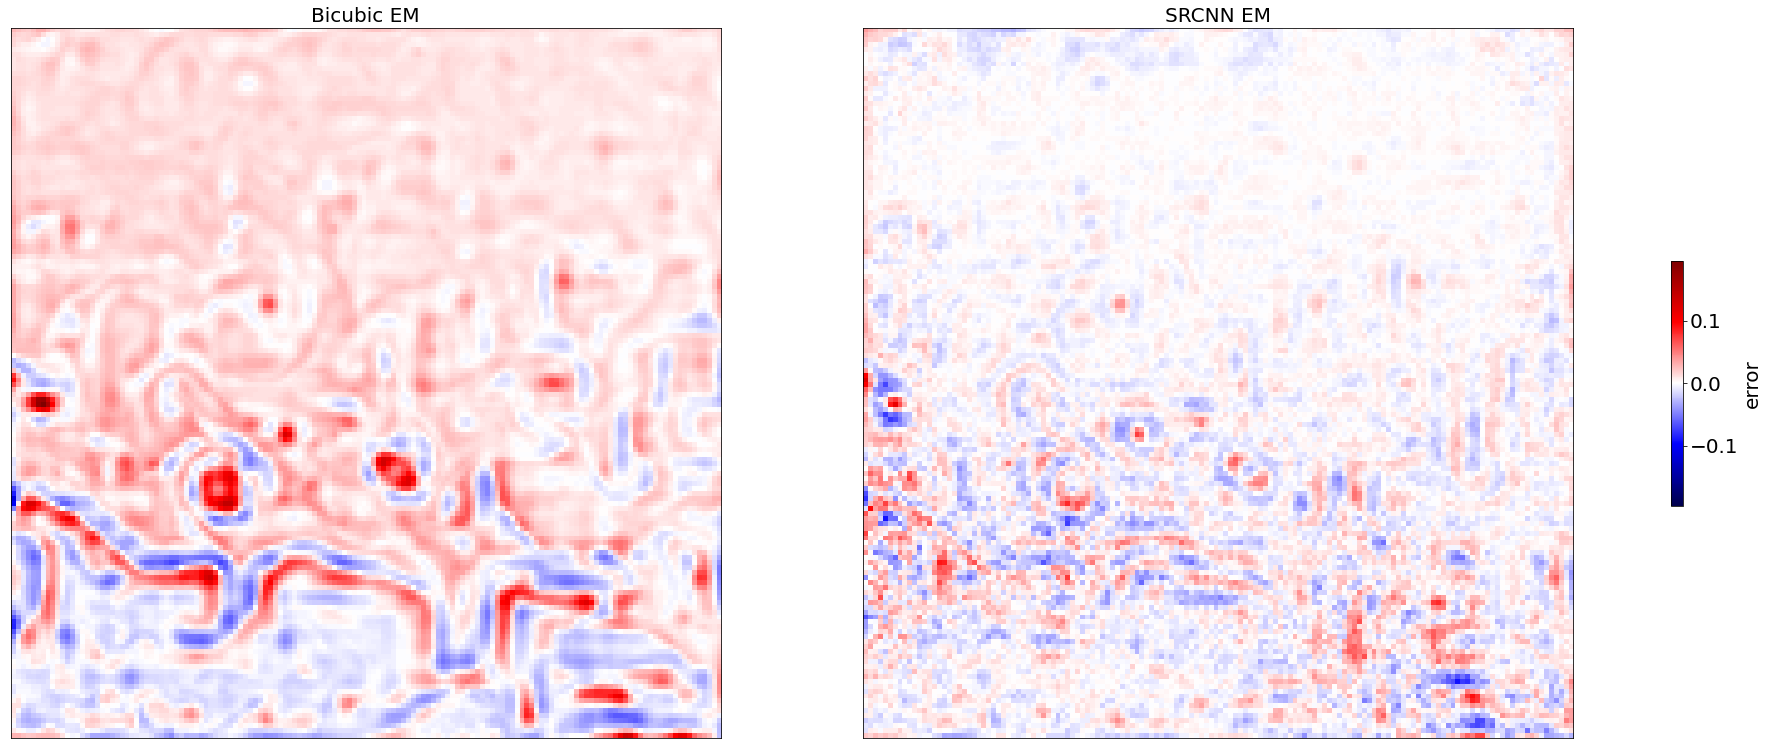

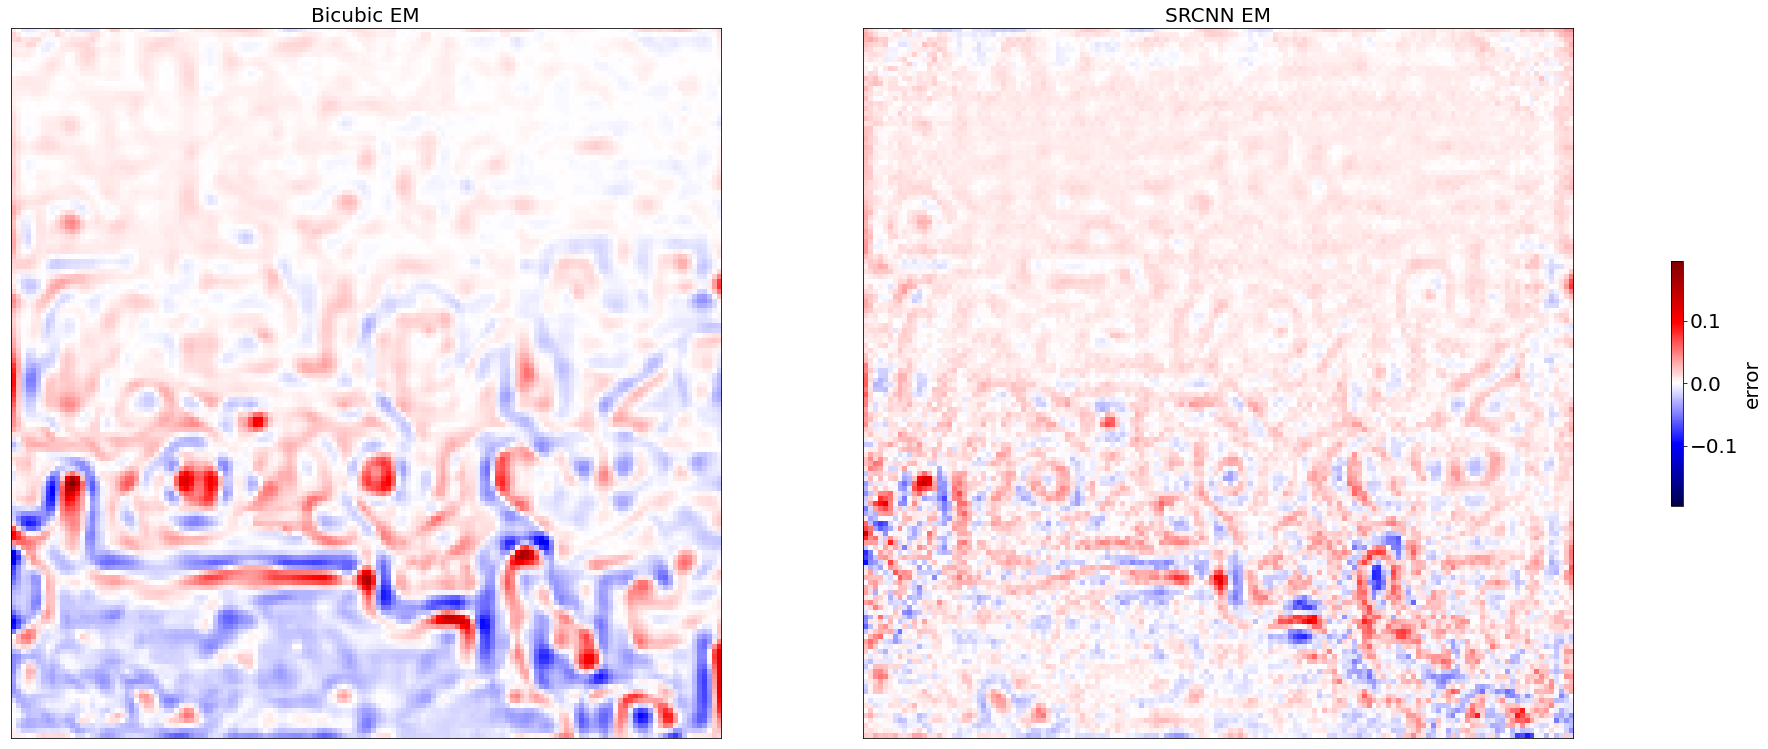

In [24]:
save_path = "./Save/exp2_srcnn_em"
for i in range(0,30,10):
    plot_line(
        [bicubic_predictions[i]-ssh_R09[i], srcnn_predictions[i]-ssh_R09[i]], 
        ["Bicubic EM", "SRCNN EM"], 
        "seismic",
        save_path+str(i), 
        label="error",
        center_colormap=True
    )

*Comment* : Here we sea much more clearly the *'checkerboard artifacts'* with the SRCNN, especially on 2x2 and 3x3 regions.

## DIPCI

### Low Resolution

In [6]:
dipci, callbacks, epochs, checkpoint_filepath = compile()

2022-05-19 16:52:00.811407: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-19 16:52:00.811442: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2022-05-19 16:52:00.811835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lr_input (InputLayer)          [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 hr_input (InputLayer)          [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 model_2 (Functional)           (None, None, None,   1665        ['lr_input[0][0]',               
                                1)                                'add[0][0]']              

#### Training (to skip)

Epoch 1/100
92/92 [==============================] - 84s 898ms/step - loss: 229.1123 - mse: 229.1124 - PSNR: -0.6431
Epoch 2/100
92/92 [==============================] - 84s 917ms/step - loss: 0.1062 - mse: 0.1062 - PSNR: 10.1618
Epoch 3/100
92/92 [==============================] - 84s 919ms/step - loss: 0.0465 - mse: 0.0465 - PSNR: 13.4848
Epoch 4/100
92/92 [==============================] - 86s 938ms/step - loss: 0.0315 - mse: 0.0315 - PSNR: 15.1735
Epoch 5/100
92/92 [==============================] - 86s 932ms/step - loss: 0.0227 - mse: 0.0227 - PSNR: 16.6520
Epoch 6/100
92/92 [==============================] - 86s 939ms/step - loss: 0.0183 - mse: 0.0183 - PSNR: 17.5388
Epoch 7/100
92/92 [==============================] - 86s 940ms/step - loss: 0.0137 - mse: 0.0137 - PSNR: 18.7289
Epoch 8/100
92/92 [==============================] - 87s 945ms/step - loss: 0.0120 - mse: 0.0120 - PSNR: 19.3138
Epoch 9/100
92/92 [==============================] - 90s 983ms/step - loss: 0.0113 - mse: 0.

Epoch 73/100
92/92 [==============================] - 88s 952ms/step - loss: 0.0019 - mse: 0.0019 - PSNR: 27.1729
Epoch 74/100
92/92 [==============================] - 88s 955ms/step - loss: 0.0019 - mse: 0.0019 - PSNR: 27.3162
Epoch 75/100
92/92 [==============================] - 88s 956ms/step - loss: 0.0018 - mse: 0.0018 - PSNR: 27.4796
Epoch 76/100
92/92 [==============================] - 88s 954ms/step - loss: 0.0019 - mse: 0.0019 - PSNR: 27.3205
Epoch 77/100
92/92 [==============================] - 88s 960ms/step - loss: 0.0018 - mse: 0.0018 - PSNR: 27.5390
Epoch 78/100
92/92 [==============================] - 88s 951ms/step - loss: 0.0017 - mse: 0.0017 - PSNR: 27.6042
Epoch 79/100
92/92 [==============================] - 88s 954ms/step - loss: 0.0017 - mse: 0.0017 - PSNR: 27.6000
Epoch 80/100
92/92 [==============================] - 88s 959ms/step - loss: 0.0017 - mse: 0.0017 - PSNR: 27.6711
Epoch 81/100
92/92 [==============================] - 88s 953ms/step - loss: 0.0018 - ms

INFO:tensorflow:Assets written to: tmp/model/dipci/assets


INFO:tensorflow:Assets written to: tmp/model/dipci/assets


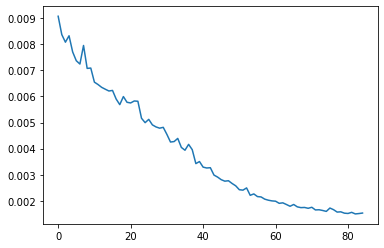

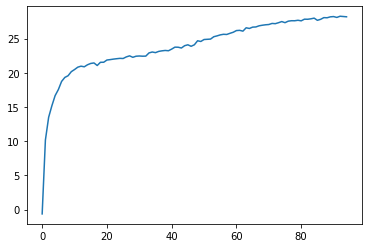

In [7]:
train(dipci, ssh_R72, sst_R36, ssh_R18_norm, callbacks, epochs)

#### Results

In [8]:
dipci.load_weights(checkpoint_filepath)

In [9]:
save_path = "./Save/exp1_dipci_plot"
bicubic_predictions, bicubic_rmse, bicubic_psnr = bicubicMetrics( ssh_R72, ssh_R18 )
dipci_predictions, dipci_rmse, dipci_psnr = dipciMetrics( dipci, ssh_R72, sst_R36, ssh_R18)

print("Average bicubic RMSE (m): ", np.mean(bicubic_rmse))
print("Average bicubic PSNR: ", np.mean(bicubic_psnr))
print("Average dipci RMSE (m): ", np.mean(dipci_rmse))
print("Average dipci PSNR: ", np.mean(dipci_psnr))

Average bicubic RMSE (m):  0.14560837199765492
Average bicubic PSNR:  23.04621296821734
Average dipci RMSE (m):  0.14059206364305676
Average dipci PSNR:  23.376489210996773


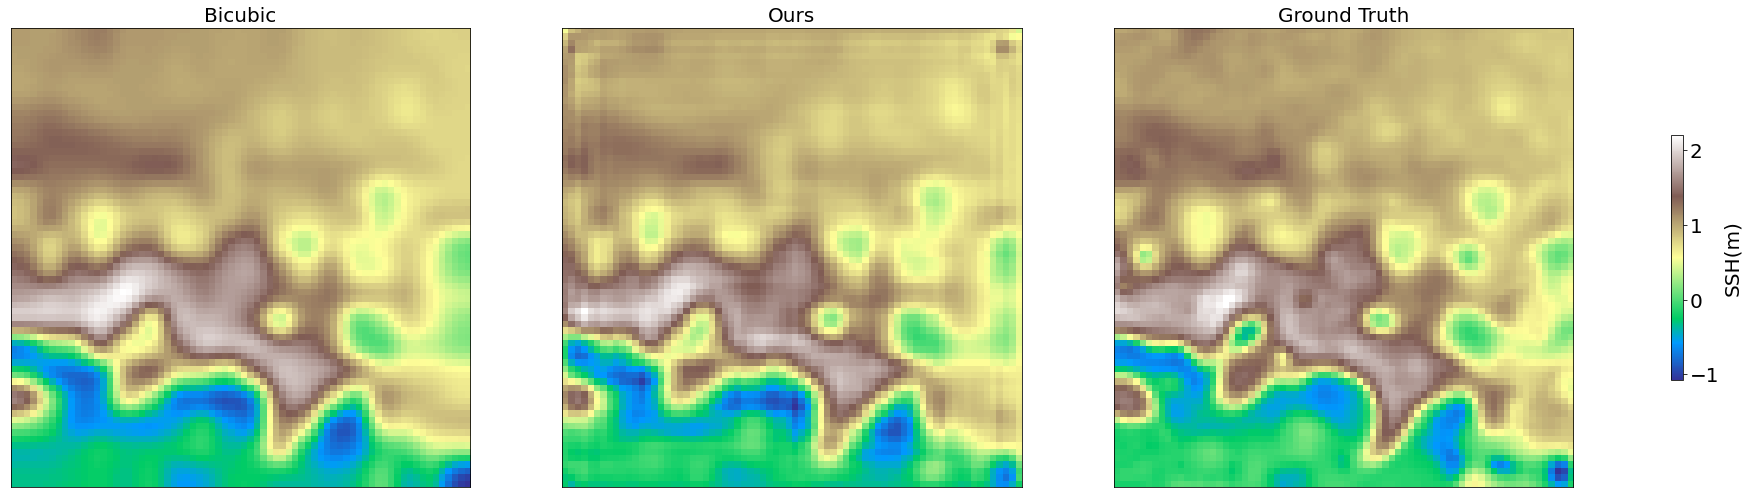

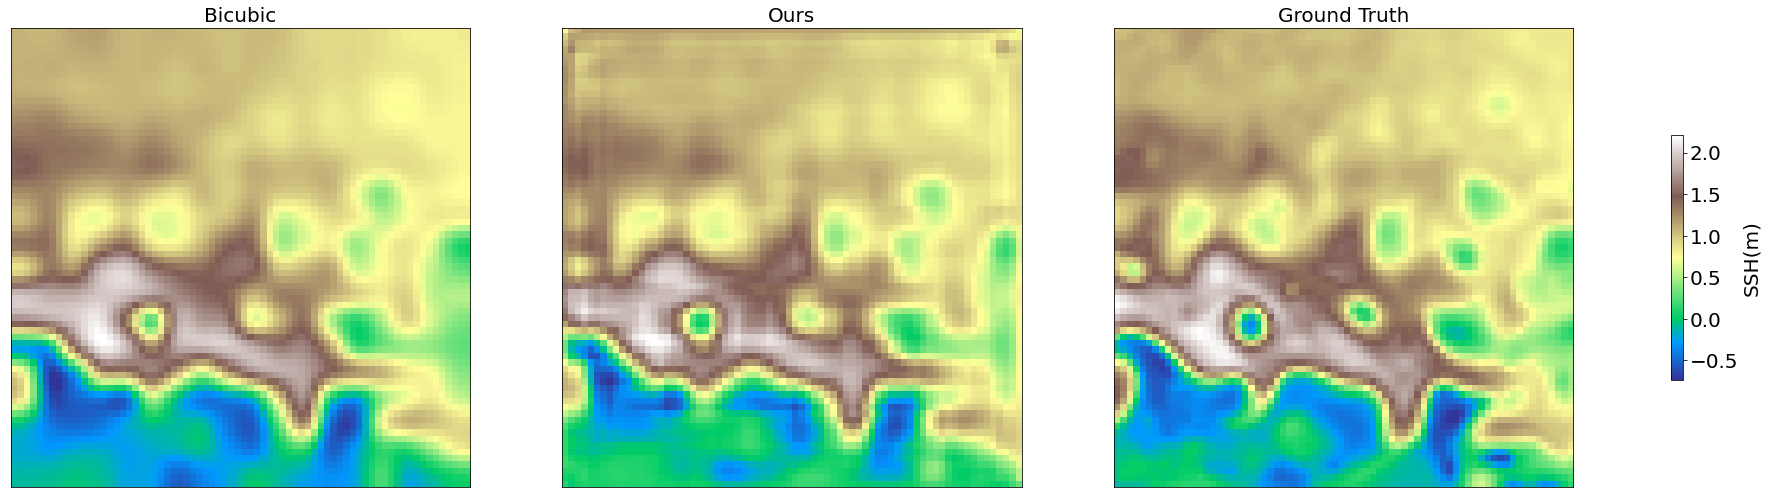

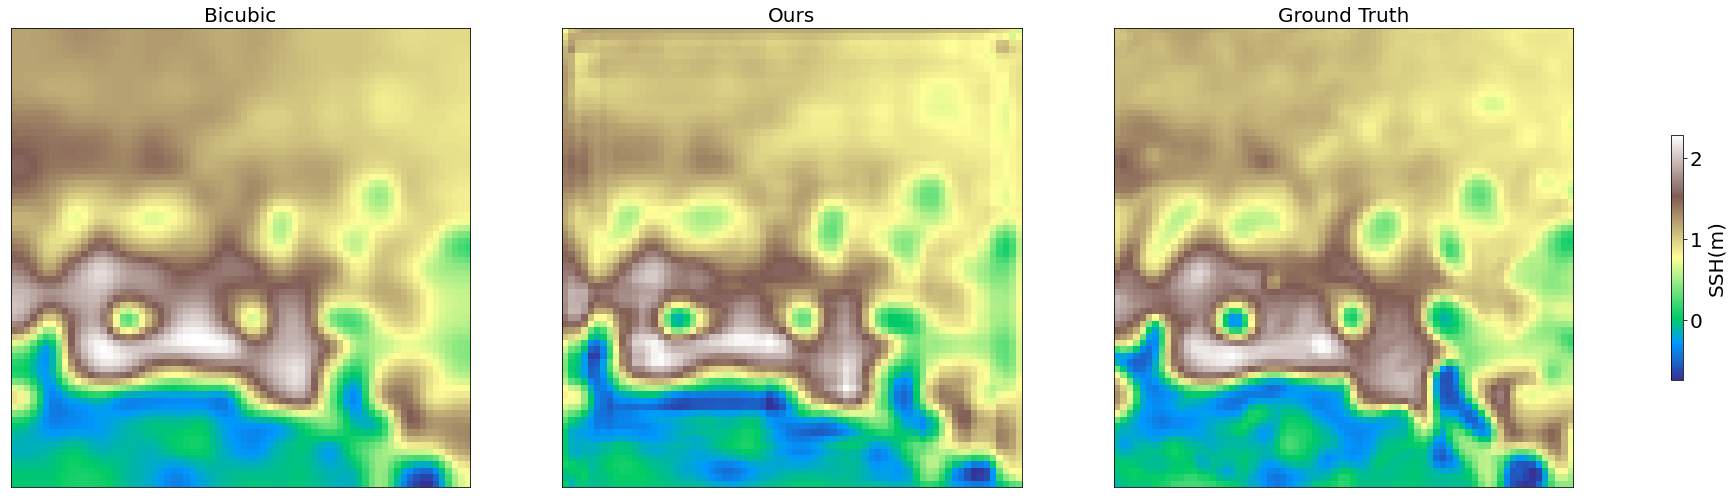

In [10]:
for i in range(3):
    plot_line(
        [bicubic_predictions[i*10], 
         dipci_predictions[i*10], 
         ssh_R18[i*10]], 
        ["Bicubic", "Ours", "Ground Truth"], 
        "terrain", 
        save_path+str(i), 
        center_colormap=False
    )

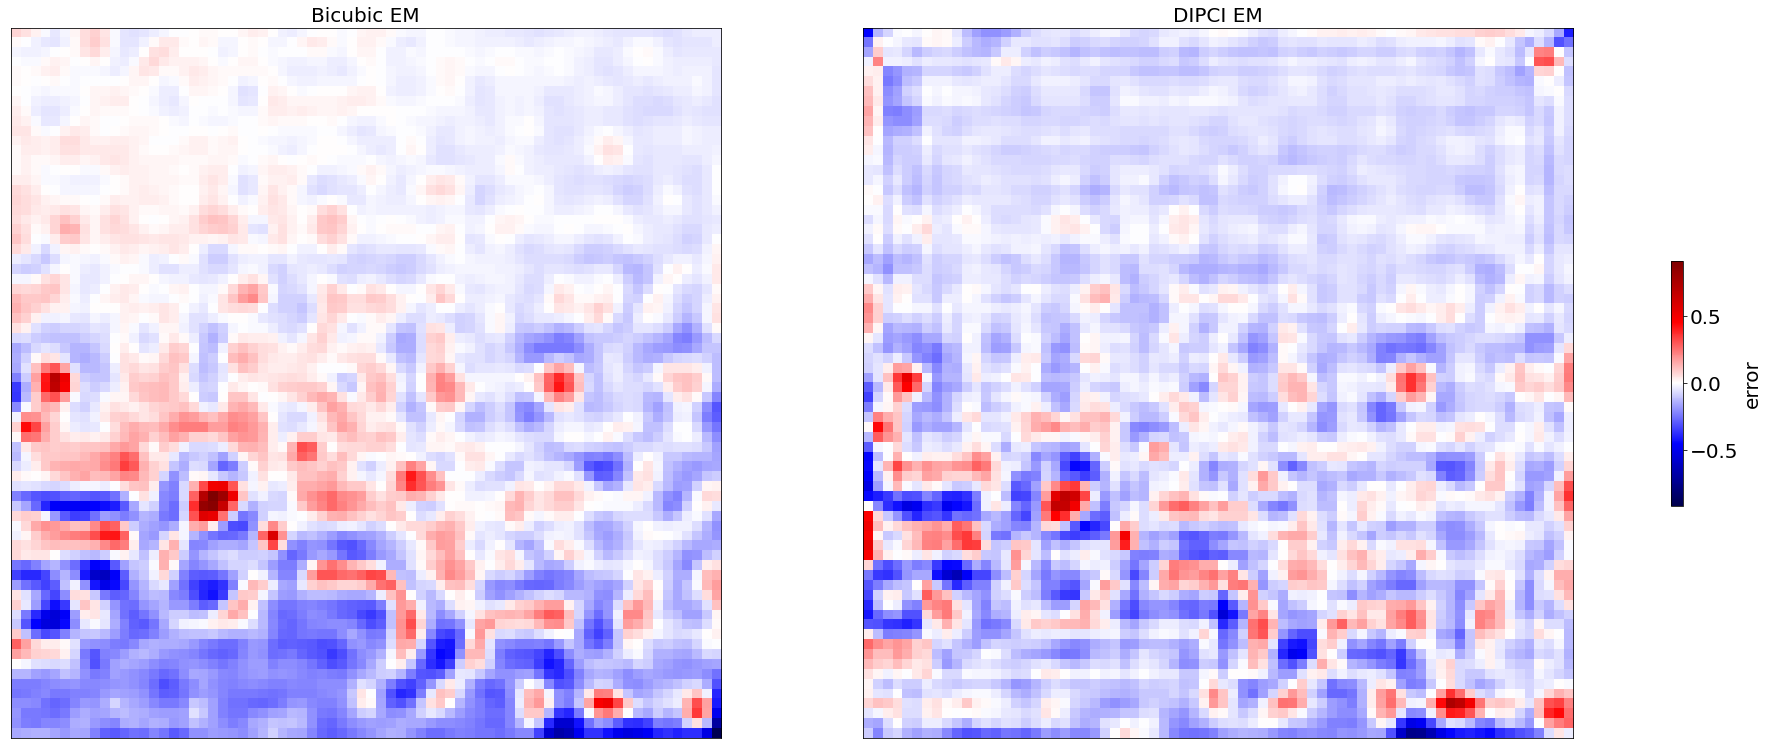

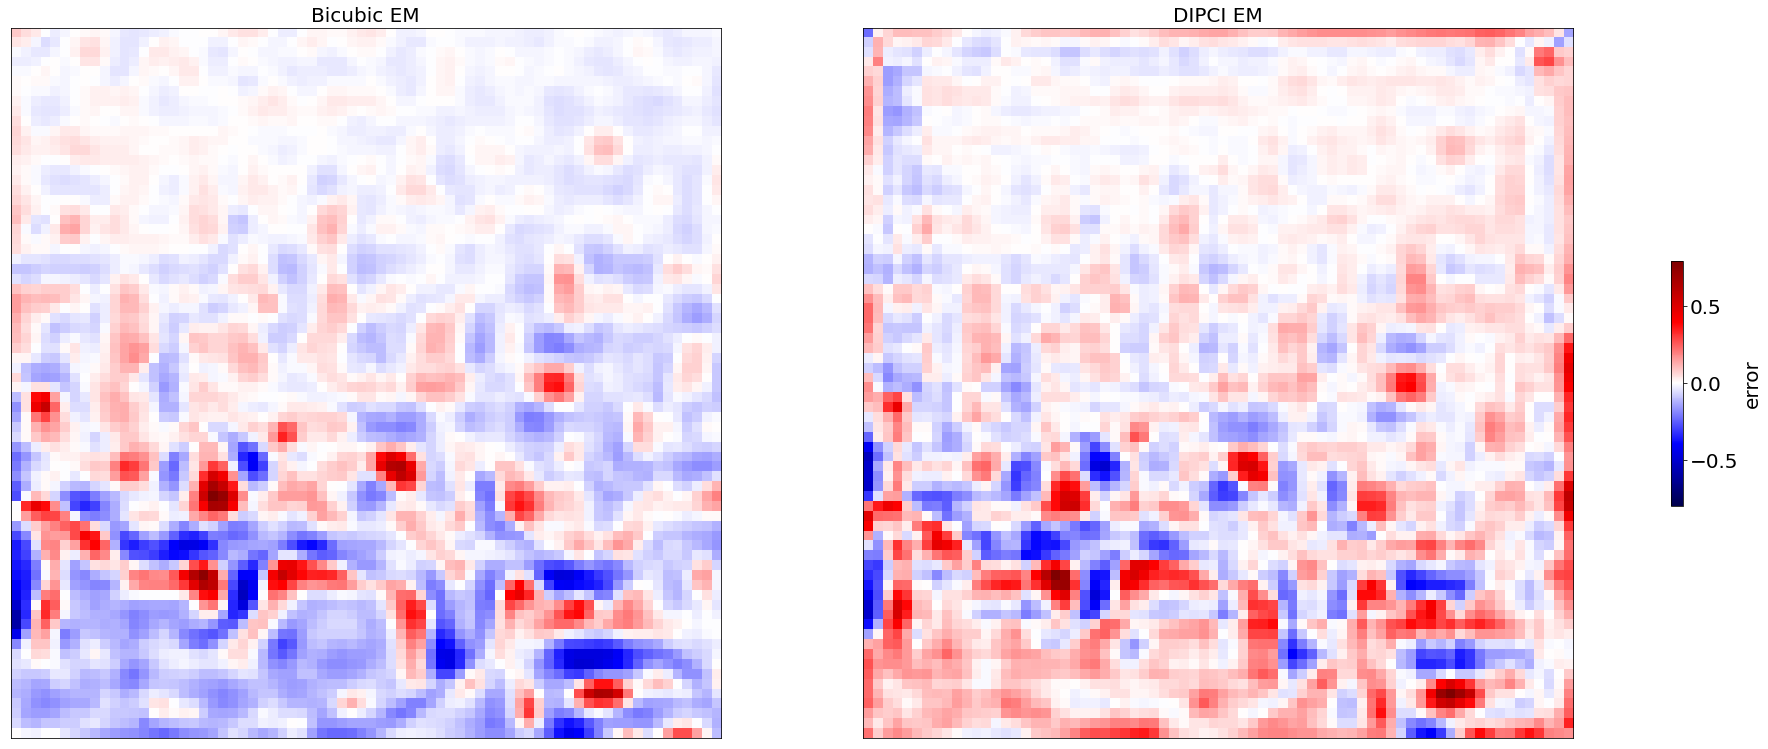

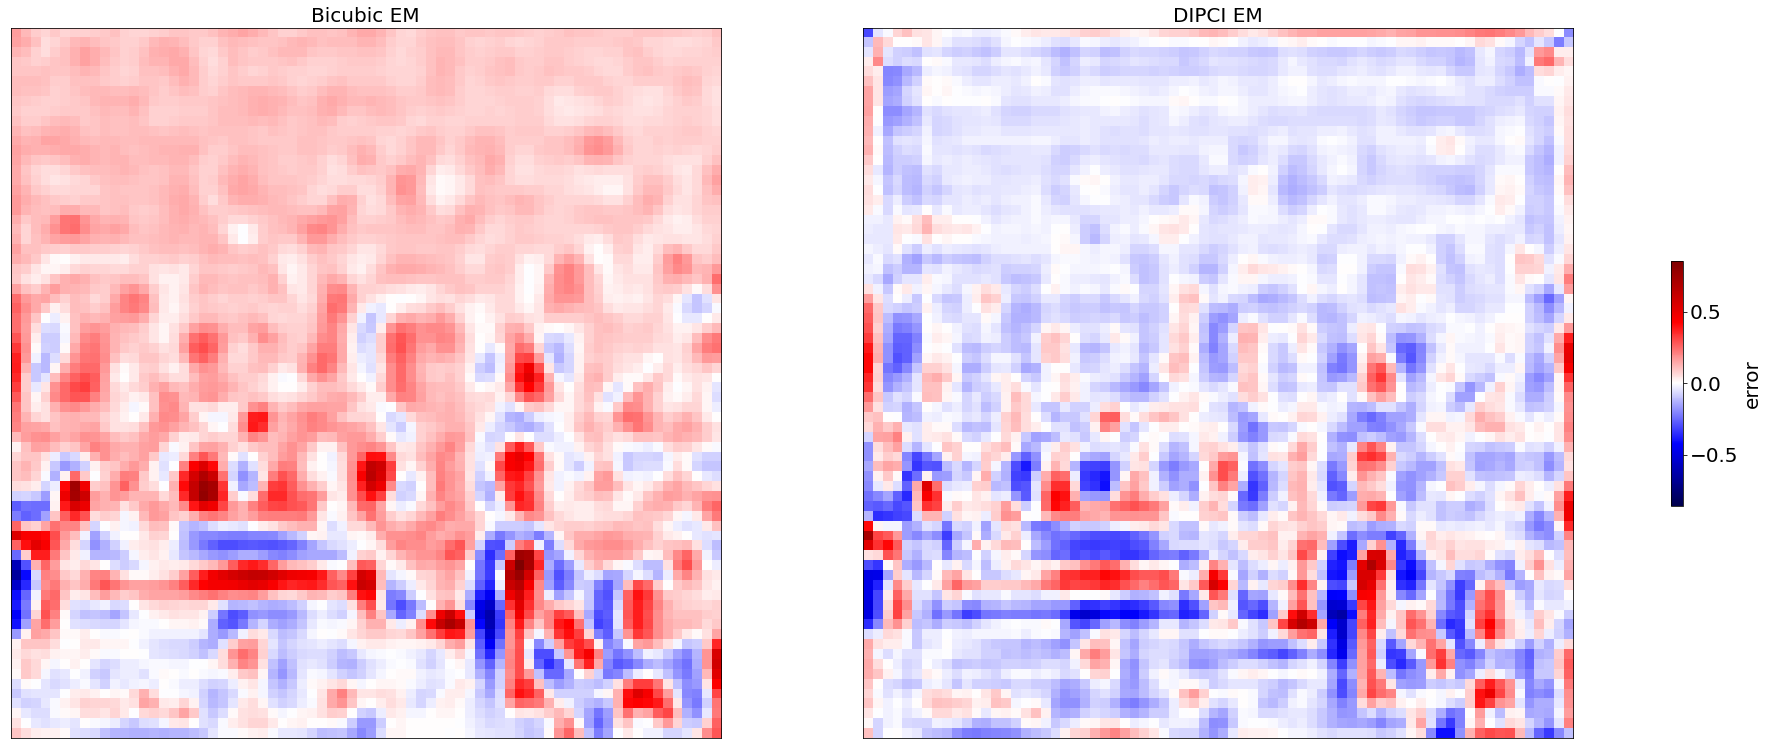

In [13]:
save_path = "./Save/exp1_dipci_em"
for i in range(0,30,10):
    plot_line(
        [bicubic_predictions[i]-ssh_R18[i], dipci_predictions[i]-ssh_R18[i]], 
        ["Bicubic EM", "DIPCI EM"], 
        "seismic",
        save_path+str(i), 
        label="error",
        center_colormap=True
    )

In [ ]:
#dipci.load_weights(checkpoint_filepath)

### High Resolution

In [8]:
train(dipci, ssh_R36, sst_R18, ssh_R09_norm, callbacks, epochs)

Epoch 1/100
 3/46 [>.............................] - ETA: 5:14 - loss: 26599.8535 - mse: 26599.8574 - PSNR: -13.3828

KeyboardInterrupt: 